# Plot Backend

Plots the APE, RPE and trajectory against ground truth for the final backend output trajectory.

In [1]:
import yaml
import os
import copy
import pandas as pd
import numpy as np

import logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.handlers:
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter('%(levelname)s - %(message)s'))
    log.addHandler(ch)
    
from evo.tools import file_interface
from evo.tools import plot
from evo.tools import pandas_bridge

from evo.core import sync
from evo.core import trajectory
from evo.core import metrics
from evo.core import transformations
from evo.core import lie_algebra as lie

%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt

In [11]:
# Define directory to VIO output csv files as well as ground truth absolute poses.
# vio_output_dir = "/home/marcus/code/VIO/output_logs/test_3/"
vio_output_dir = "/home/marcus/catkin_ws/src/spark_vio_ros/output_logs/test_4/"
# gt_data_file = "/home/marcus/datasets/V1_01_easy/mav0/state_groundtruth_estimate0/data.csv"
gt_data_file = "/home/marcus/catkin_ws/src/spark_vio_ros/output_logs/test_4/output_gt_poses.csv"

In [12]:
# Useful methods for RPE calculation.

def get_rpe(data, metric):
    """ Gets RPE and RPE statistics for two trajectories and a given pose_relation.
        
        Args:
            data:   tuple of trajectories, the first being the reference trajectory
                    and the second being the estimated trajectory.
            metric: a metrics.PoseRelation instance representing the pose relation
                    to use when computing RPE.
        
        Returns:
            A metrics.RPE instance containing the RPE for both trajectories according
            to the given metric.
    """
    # normal mode
    delta = 1
    delta_unit = metrics.Unit.frames
    all_pairs = False

    rpe = metrics.RPE(metric, delta, delta_unit, all_pairs)
    rpe.process_data(data)
    return rpe


def plot_rpe(x_axis, rpe, size=(18,10)):
    """ Plots RPE error against time for a given metrics.RPE instance.
    
        Args:
            x_axis: An array-type of values for all the x-axis values (time).
            rpe:    A metrics.RPE instance with pre-processed data.
    """
    fig = plt.figure(figsize=size)
    plot.error_array(fig, rpe.error, x_array=x_axis, statistics=rpe.get_all_statistics(), 
                     name="RPE", title="RPE w.r.t. " + rpe.pose_relation.value, xlabel="$t$ (s)")
    plt.show()


def rename_euroc_gt_df(df):
    """ Renames a DataFrame built from a EuRoC ground-truth data csv file to be easier to read.
        
        Column labels are changed to be more readable and to be identical to the generic pose 
        trajectory format used with other csv files. Note that '#timestamp' will not actually 
        be renamed if it is the index of the DataFrame (which it should be). It will be 
        appropriately renamed if it is the index name.
        This operation is 'inplace': It does not return a new DataFrame but simply changes
        the existing one.
        
        Args:
            df: A pandas.DataFrame object.
    """
    df.index.names = ["timestamp"]
    df.rename(columns={" p_RS_R_x [m]": "x",
                       " p_RS_R_y [m]": "y",
                       " p_RS_R_z [m]": "z",
                       " q_RS_w []": "qw",
                       " q_RS_x []": "qx",
                       " q_RS_y []": "qy",
                       " q_RS_z []": "qz",
                       " v_RS_R_x [m s^-1]": "vx",
                       " v_RS_R_y [m s^-1]": "vy",
                       " v_RS_R_z [m s^-1]": "vz",
                       " b_w_RS_S_x [rad s^-1]": "bgx",
                       " b_w_RS_S_y [rad s^-1]": "bgy",
                       " b_w_RS_S_z [rad s^-1]": "bgz",
                       " b_a_RS_S_x [m s^-2]": "bax",
                       " b_a_RS_S_y [m s^-2]": "bay",
                       " b_a_RS_S_z [m s^-2]": "baz"}, inplace=True)

In [13]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)

output_poses_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_posesVIO.csv")
output_poses_df = pd.read_csv(output_poses_filename, sep=',', index_col=0)

In [14]:
gt_df = gt_df[~gt_df.index.duplicated()]

In [15]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref = pandas_bridge.df_to_trajectory(gt_df)

# Use the mono ransac file as estimated trajectory.
# traj_est_unassociated = file_interface.read_swe_csv_trajectory(ransac_mono_filename)
traj_est_unaligned = pandas_bridge.df_to_trajectory(output_poses_df)

# Associate the data.
traj_est = copy.deepcopy(traj_est_unaligned)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)
traj_est = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False)

print "traj_ref: ", traj_ref
print "traj_est: ", traj_est

traj_ref:  243 poses, 119.648m path length, 55.259s duration
traj_est:  243 poses, 4812.206m path length, 55.259s duration


In [16]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe((traj_ref, traj_est), metrics.PoseRelation.rotation_angle_deg)
rpe_tran = get_rpe((traj_ref, traj_est), metrics.PoseRelation.translation_part)

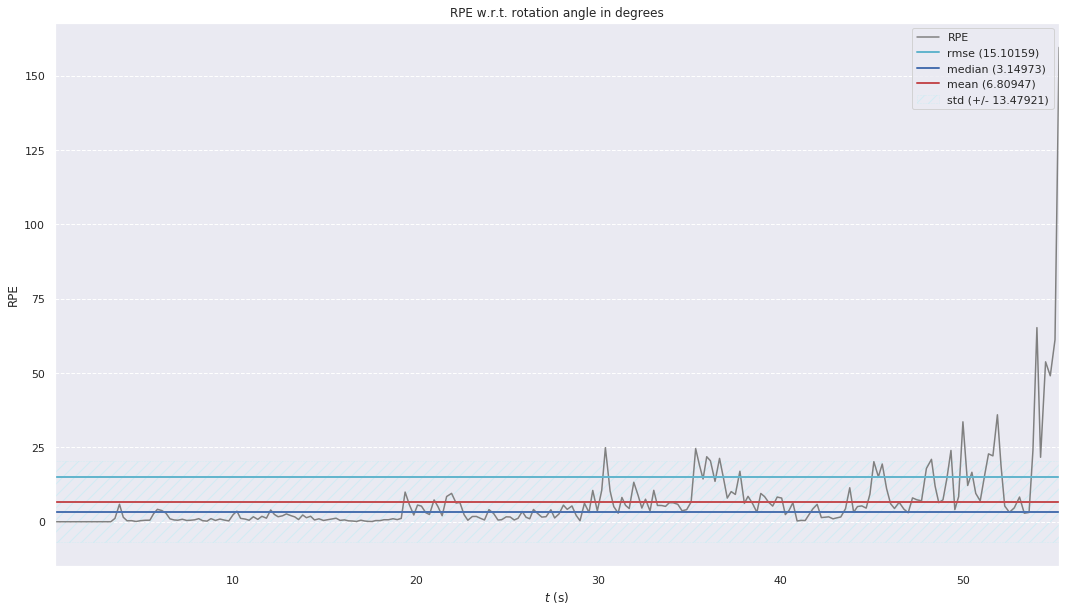

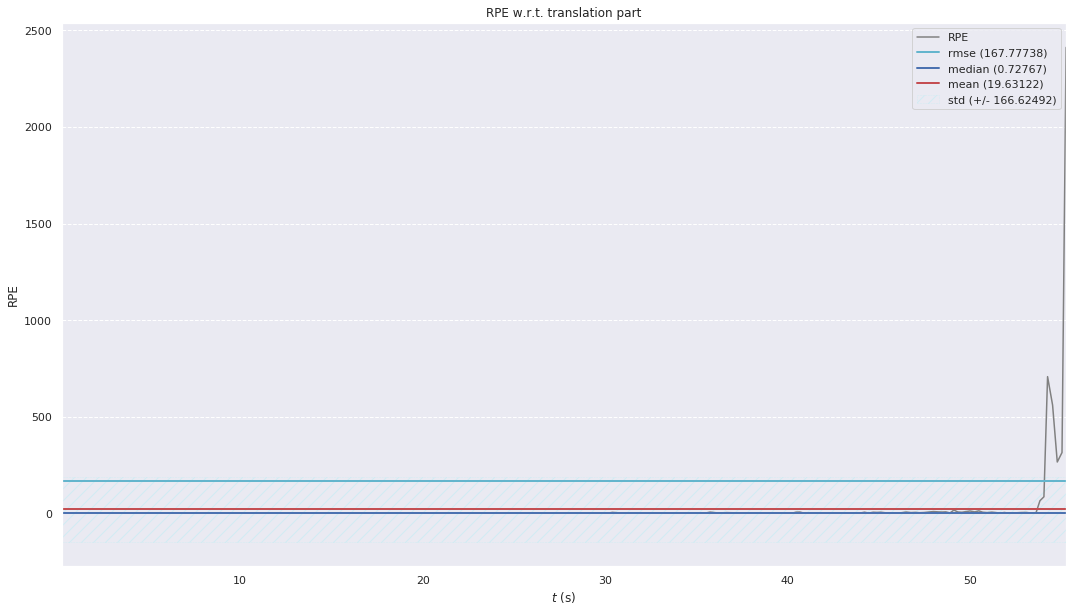

In [17]:
# Plot RPE of trajectory rotation and translation parts.

# important: restrict data to delta ids for plot.
traj_ref_plot = copy.deepcopy(traj_ref)
traj_est_plot = copy.deepcopy(traj_est)
traj_ref_plot.reduce_to_ids(rpe_rot.delta_ids)
traj_est_plot.reduce_to_ids(rpe_rot.delta_ids)
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

plot_rpe(seconds_from_start, rpe_rot)
plot_rpe(seconds_from_start, rpe_tran)

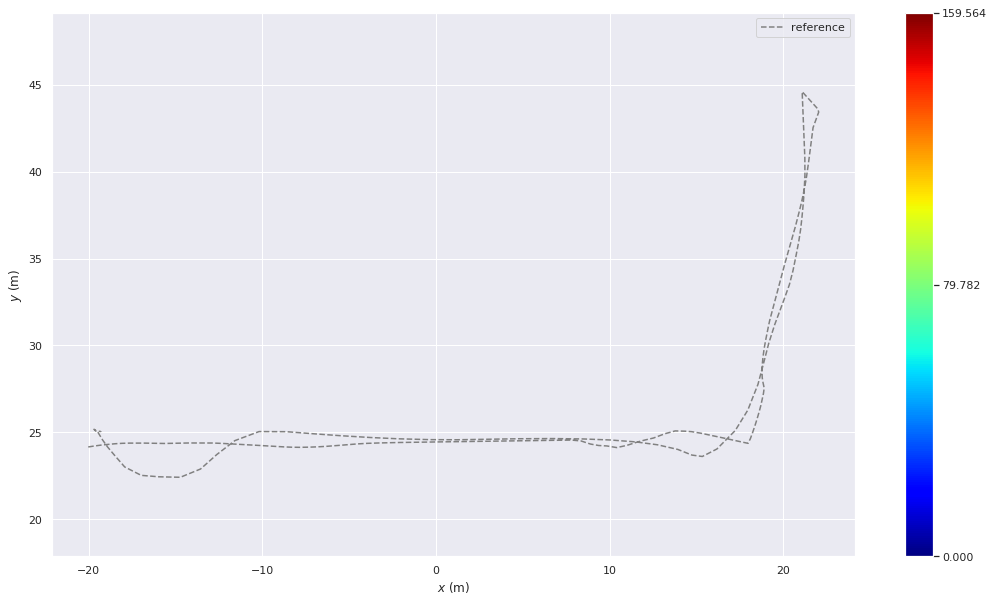

In [18]:
# Plot the relative trajectories against each other. This is only for visualizing large error.
# TODO(marcus): decide on usefulness.

plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(18,10))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref_plot, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_plot, rpe_rot.error, plot_mode,
                   min_map=rpe_rot.get_all_statistics()["min"],
                   max_map=rpe_rot.get_all_statistics()["max"])
ax.legend()
plt.show()

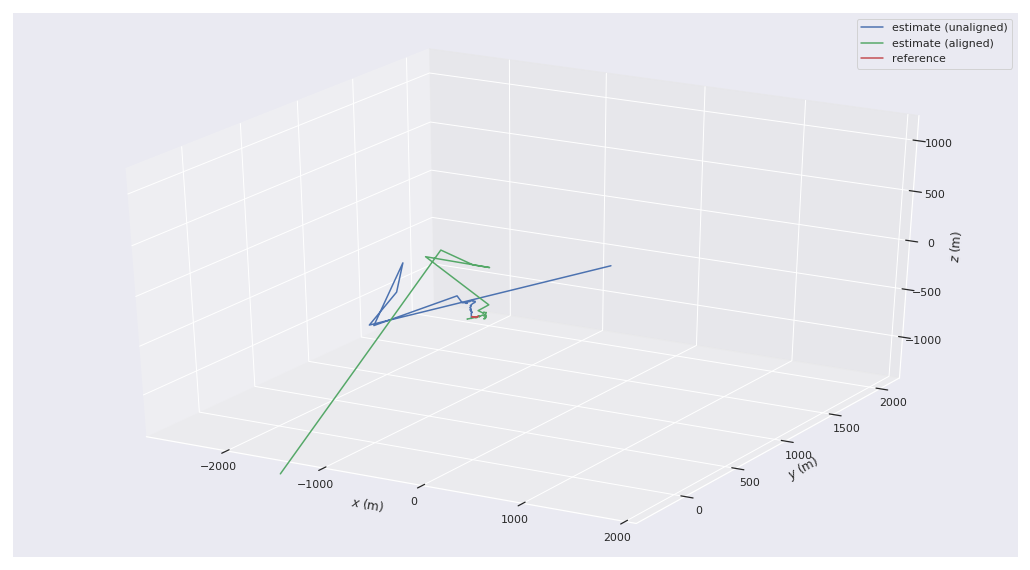

In [19]:
# Plot the trajectories for quick error visualization.
# TODO(marcus): decide on usefulness.

fig = plt.figure(figsize=(18,10))
traj_by_label = {
    "estimate (unaligned)": traj_est_unaligned,
    "estimate (aligned)": traj_est,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()